<a href="https://colab.research.google.com/github/RPM247/Change-Detection-using-Satellite-Images/blob/main/Trial002_Neglecting_unchanged_pixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio geopandas matplotlib numpy torch torchvision segmentation-models-pytorch earthengine-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')

INPUT_FOLDER = "/content/drive/MyDrive/Gujarat_Satellite_Data"
OUTPUT_CHIPS_DIR = "/content/temp_chips/train"

os.makedirs(OUTPUT_CHIPS_DIR, exist_ok=True)

print(f"📂 Reading 6-band data from: {INPUT_FOLDER}")
print(f"📂 Saving filtered chips to: {OUTPUT_CHIPS_DIR}")

Mounted at /content/drive
📂 Reading 6-band data from: /content/drive/MyDrive/Gujarat_Satellite_Data
📂 Saving filtered chips to: /content/temp_chips/train


In [3]:
import rasterio
from rasterio.windows import Window
import numpy as np
import glob
import os
import random
from tqdm import tqdm

CHIP_SIZE = 256
STRIDE = 128
DISTRICT_TARGET = "Ahmadabad"
PROCESS_CHUNK_SIZE = 2048
INPUT_FOLDER = "/content/drive/MyDrive/Gujarat_Satellite_Data"
OUTPUT_CHIPS_DIR = "/content/temp_chips/train"

# --- 1. Define Math Functions ---
def calculate_ndvi(nir, red):
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir - red) / (nir + red + 1e-8)
    return np.nan_to_num(ndvi, nan=-1.0)

def calculate_ndbi(swir, nir):
    with np.errstate(divide='ignore', invalid='ignore'):
        ndbi = (swir - nir) / (swir + nir + 1e-8)
    return np.nan_to_num(ndbi, nan=-1.0)

def calculate_mndwi(green, swir):
    with np.errstate(divide='ignore', invalid='ignore'):
        mndwi = (green - swir) / (green + swir + 1e-8)
    return np.nan_to_num(mndwi, nan=-1.0)

def create_training_data():
    all_files = sorted(glob.glob(f"{INPUT_FOLDER}/*.tif"))
    district_files = [f for f in all_files if DISTRICT_TARGET.lower() in f.lower()]

    if len(district_files) < 2:
        print(f"❌ Error: Need at least 2 images for {DISTRICT_TARGET}.")
        return

    print(f"📍 Found {len(district_files)} images. Applying RAM-Safe Processing...")

    kept_chips = 0

    # Sort files to ensure we match years correctly (2017 -> 2018 -> etc.)
    # This assumes you have 1 file per year per district (standard GEE export)
    # If GEE split your district into multiple tiles (e.g., Ahmedabad_2018_1.tif, Ahmedabad_2018_2.tif),
    # this logic pairs them sequentially.

    # Simple pairing: File 1 & File 2, File 2 & File 3...
    for i in range(len(district_files) - 1):
        file1 = district_files[i]
        file2 = district_files[i+1]

        # Check if they are actually consecutive years (optional safety)
        # year1 = os.path.basename(file1).split('_')[1]
        # year2 = os.path.basename(file2).split('_')[1]

        print(f"🔨 Processing Pair: {os.path.basename(file1)} -> {os.path.basename(file2)}")

        with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
            height = src1.height
            width = src1.width

            # --- CHUNK PROCESSING (The RAM Saver) ---
            # We read only 2048x2048 pixels at a time
            for y_offset in tqdm(range(0, height, PROCESS_CHUNK_SIZE), desc="   Processing Rows"):
                for x_offset in range(0, width, PROCESS_CHUNK_SIZE):

                    # Define the window to read
                    window = Window(x_offset, y_offset,
                                  min(PROCESS_CHUNK_SIZE, width - x_offset),
                                  min(PROCESS_CHUNK_SIZE, height - y_offset))

                    # Load ONLY this chunk into RAM
                    p1 = src1.read(window=window)
                    p2 = src2.read(window=window)

                    # Align shapes (handle edge cases)
                    h_chunk = min(p1.shape[1], p2.shape[1])
                    w_chunk = min(p1.shape[2], p2.shape[2])
                    p1 = p1[:, :h_chunk, :w_chunk]
                    p2 = p2[:, :h_chunk, :w_chunk]

                    # Skip empty blocks
                    if np.max(p1) == 0: continue

                    # --- Calculate Indices (Chunk Level) ---
                    # [0]=Blue, [1]=Green, [2]=Red, [3]=NIR, [4]=SWIR1, [5]=SWIR2

                    ndvi1 = calculate_ndvi(p1[3], p1[2])
                    ndvi2 = calculate_ndvi(p2[3], p2[2])

                    ndbi1 = calculate_ndbi(p1[4], p1[3])
                    ndbi2 = calculate_ndbi(p2[4], p2[3])

                    mndwi1 = calculate_mndwi(p1[1], p1[4])
                    mndwi2 = calculate_mndwi(p2[1], p2[4])

                    diff_ndvi = ndvi2 - ndvi1
                    diff_ndbi = ndbi2 - ndbi1
                    diff_mndwi = mndwi2 - mndwi1

                    # --- Create Mask (Chunk Level) ---
                    label_mask_chunk = np.zeros((h_chunk, w_chunk), dtype=np.uint8)

                    # Level 1: Veg
                    label_mask_chunk[diff_ndvi < -0.15] = 1 # Loss
                    label_mask_chunk[diff_ndvi > 0.15] = 2  # Gain

                    # Level 2: Urban
                    urban_change = (diff_ndbi > 0.15) & (ndbi1 < 0.1)
                    label_mask_chunk[urban_change] = 3

                    # Level 3: Water
                    water_change = (np.abs(diff_mndwi) > 0.20) & ((mndwi1 > 0) | (mndwi2 > 0))
                    label_mask_chunk[water_change] = 4

                    # --- Chip Slicing (Inner Loop) ---
                    # Now we slice the 2048 chunk into 256 chips
                    for y in range(0, h_chunk - CHIP_SIZE, STRIDE):
                        for x in range(0, w_chunk - CHIP_SIZE, STRIDE):

                            mask_patch = label_mask_chunk[y:y+CHIP_SIZE, x:x+CHIP_SIZE]
                            change_pixels = np.count_nonzero(mask_patch)

                            # --- Smart Filter ---
                            should_save = False
                            if change_pixels > 50:
                                should_save = True
                            elif random.random() < 0.05: # Context
                                if np.mean(p1[:, y:y+CHIP_SIZE, x:x+CHIP_SIZE]) > 10:
                                    should_save = True

                            if should_save:
                                # Extract image patches from the chunk
                                chip1 = p1[:, y:y+CHIP_SIZE, x:x+CHIP_SIZE]
                                chip2 = p2[:, y:y+CHIP_SIZE, x:x+CHIP_SIZE]

                                combined = np.concatenate((chip1, chip2), axis=0)

                                np.save(f"{OUTPUT_CHIPS_DIR}/img_{kept_chips}.npy", combined.astype(np.float16))
                                np.save(f"{OUTPUT_CHIPS_DIR}/mask_{kept_chips}.npy", mask_patch)
                                kept_chips += 1

    print(f"✅ Preprocessing Done. Total chips: {kept_chips}")

create_training_data()

📍 Found 9 images. Applying RAM-Safe Processing...
🔨 Processing Pair: Ahmadabad_2017_10m.tif -> Ahmadabad_2018_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:24<00:00, 16.08s/it]


🔨 Processing Pair: Ahmadabad_2018_10m.tif -> Ahmadabad_2019_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:15<00:00, 15.07s/it]


🔨 Processing Pair: Ahmadabad_2019_10m.tif -> Ahmadabad_2020_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:44<00:00, 18.26s/it]


🔨 Processing Pair: Ahmadabad_2020_10m.tif -> Ahmadabad_2021_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:43<00:00, 18.22s/it]


🔨 Processing Pair: Ahmadabad_2021_10m.tif -> Ahmadabad_2022_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:53<00:00, 19.33s/it]


🔨 Processing Pair: Ahmadabad_2022_10m.tif -> Ahmadabad_2023_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:15<00:00, 15.03s/it]


🔨 Processing Pair: Ahmadabad_2023_10m.tif -> Ahmadabad_2024_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:56<00:00, 19.64s/it]


🔨 Processing Pair: Ahmadabad_2024_10m.tif -> Ahmadabad_2025_10m.tif


   Processing Rows: 100%|██████████| 9/9 [02:19<00:00, 15.54s/it]

✅ Preprocessing Done. Total chips: 36296


In [6]:
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader

class ChangeDetectionDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob.glob(f"{data_dir}/img_*.npy"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        mask_path = img_path.replace("img_", "mask_")

        try:
            image = np.load(img_path).astype(np.float32)
            mask = np.load(mask_path).astype(np.longlong)
            image = np.clip(image, 0, 3000) / 3000.0
            return torch.from_numpy(image), torch.from_numpy(mask)
        except Exception as e:
            return torch.zeros((12, 256, 256), dtype=torch.float32), \
                   torch.zeros((256, 256), dtype=torch.long)

print(f"📂 Loading dataset from: {OUTPUT_CHIPS_DIR}")
dataset = ChangeDetectionDataset(OUTPUT_CHIPS_DIR)

if len(dataset) > 0:
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"✅ Data Loaded! Training on {len(train_dataset)} curated samples.")
else:
    print("❌ Error: No chips found.")

📂 Loading dataset from: /content/temp_chips/train
✅ Data Loaded! Training on 29036 curated samples.


In [7]:
import segmentation_models_pytorch as smp

model = smp.Segformer(
    encoder_name="mit_b3",
    encoder_weights="imagenet",
    in_channels=12,
    classes=5
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
print(f"🤖 Model loaded on {DEVICE} (12 Inputs -> 5 Classes)")

🤖 Model loaded on cpu (12 Inputs -> 5 Classes)


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

LR = 0.0001
EPOCHS = 20
SAVE_PATH = "/content/drive/MyDrive/ahmedabad_segformer_5class.pth"

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
scaler = GradScaler()

best_val_loss = float('inf')

print("🚀 Starting Training (5-Class Detection)...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    print(f"   📉 Train: {train_loss/len(train_loader):.4f} | Val: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), SAVE_PATH)
        print("   💾 Model Saved!")

print("🏁 Training Complete!")

/tmp/ipython-input-2729988170.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🚀 Starting Training (5-Class Detection)...


Epoch 1/20:   0%|          | 0/454 [00:00<?, ?it/s]/tmp/ipython-input-2729988170.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20: 100%|██████████| 454/454 [08:38<00:00,  1.14s/it]
/tmp/ipython-input-2729988170.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   📉 Train: 0.2131 | Val: 0.1888
   💾 Model Saved!


Epoch 2/20: 100%|██████████| 454/454 [09:24<00:00,  1.24s/it]


   📉 Train: 0.1862 | Val: 0.1796
   💾 Model Saved!


Epoch 3/20: 100%|██████████| 454/454 [09:27<00:00,  1.25s/it]


   📉 Train: 0.1777 | Val: 0.1721
   💾 Model Saved!


Epoch 4/20: 100%|██████████| 454/454 [09:44<00:00,  1.29s/it]


   📉 Train: 0.1734 | Val: 0.1683
   💾 Model Saved!


Epoch 5/20: 100%|██████████| 454/454 [09:03<00:00,  1.20s/it]


   📉 Train: 0.1706 | Val: 0.1650
   💾 Model Saved!


Epoch 6/20: 100%|██████████| 454/454 [09:23<00:00,  1.24s/it]


   📉 Train: 0.1678 | Val: 0.1629
   💾 Model Saved!


Epoch 7/20: 100%|██████████| 454/454 [09:27<00:00,  1.25s/it]


   📉 Train: 0.1654 | Val: 0.1616
   💾 Model Saved!


Epoch 8/20:   0%|          | 2/454 [00:04<14:03,  1.87s/it]

✅ Model Loaded from /content/drive/MyDrive/ahmedabad_segformer_5class.pth
🔍 Processing 7710x4865 pixels | Input Bands: 6...


🚀 Inferring:   5%|▍         | 28/620 [00:00<00:12, 47.19it/s]/tmp/ipython-input-3998049325.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
🚀 Inferring: 100%|██████████| 620/620 [07:43<00:00,  1.34it/s]


🎨 Visualizing Results...


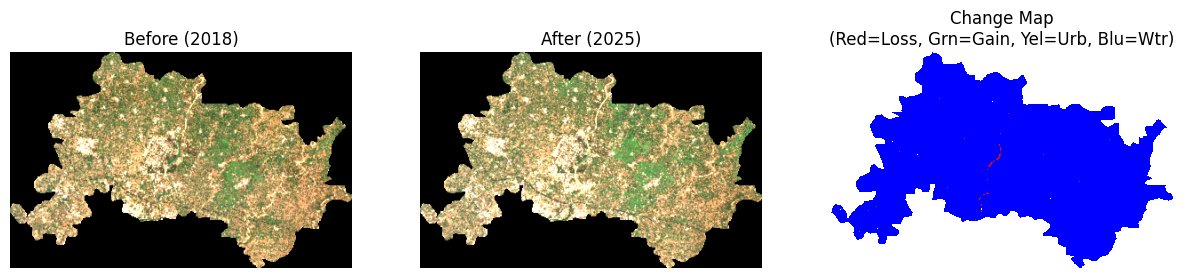

💾 Saving QGIS-Ready file to: /content/drive/MyDrive/Gandhinagar_Change_Map_QGIS_MultiClass.tif...
✅ Success! Open file in QGIS.


In [4]:
import torch
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import segmentation_models_pytorch as smp
from tqdm import tqdm
import cv2  # Make sure cv2 is available for resizing

# --- 1. CONFIGURATION ---
# Path to your NEW Multi-Class Model
MODEL_PATH = "/content/drive/MyDrive/ahmedabad_segformer_5class.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define Classes & Colors
# 0=White (No Change), 1=Red (Veg Loss), 2=Green (Veg Gain), 3=Yellow (Urban), 4=Blue (Water)
CLASSES = ['No Change', 'Veg Loss', 'Veg Gain', 'Urban', 'Water']
CMAP = ListedColormap(['white', 'red', 'green', 'yellow', 'blue'])

# --- 2. LOAD MODEL ---
# Initialize with parameters matching training (12 channels, 5 classes)
inference_model = smp.Segformer(
    encoder_name="mit_b3",
    encoder_weights=None,
    in_channels=12,
    classes=5
)

if os.path.exists(MODEL_PATH):
    inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    inference_model.to(DEVICE)
    inference_model.eval()
    print(f"✅ Model Loaded from {MODEL_PATH}")
else:
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}")

# --- 3. INFERENCE FUNCTION ---
def predict_change_safe(path_before, path_after, model=inference_model, batch_size=32):

    with rasterio.open(path_before) as src1, rasterio.open(path_after) as src2:
        h, w = src1.height, src1.width
        num_bands = src1.count
        print(f"🔍 Processing {w}x{h} pixels | Input Bands: {num_bands}...")

        full_prediction = np.zeros((h, w), dtype=np.uint8)

        chip_size = 256
        stride = 256 # No overlap needed for inference

        batch_tensors = []
        batch_locations = []

        # Create Grid
        windows = []
        for y in range(0, h, stride):
            for x in range(0, w, stride):
                windows.append((y, x))

        # Loop through grid
        for i, (y, x) in tqdm(enumerate(windows), total=len(windows), desc="🚀 Inferring"):
            window_h = min(chip_size, h - y)
            window_w = min(chip_size, w - x)
            window = Window(x, y, window_w, window_h)

            # Read Data
            img1 = src1.read(window=window)
            img2 = src2.read(window=window)

            # Pad if at edge
            pad_h = chip_size - window_h
            pad_w = chip_size - window_w
            if pad_h > 0 or pad_w > 0:
                img1 = np.pad(img1, ((0,0), (0, pad_h), (0, pad_w)), mode='constant')
                img2 = np.pad(img2, ((0,0), (0, pad_h), (0, pad_w)), mode='constant')

            # --- ADAPTIVE CHANNEL HANDLING ---
            # Model expects 12 channels (6+6). If inputs have 4 bands, pad to 6.
            if num_bands == 4:
                # Add 2 dummy bands (zeros) to make it 6 bands per image
                dummy1 = np.zeros((2, 256, 256), dtype=img1.dtype)
                dummy2 = np.zeros((2, 256, 256), dtype=img2.dtype)
                img1 = np.concatenate((img1, dummy1), axis=0)
                img2 = np.concatenate((img2, dummy2), axis=0)

            # Normalize
            img1 = np.clip(img1, 0, 3000) / 3000.0
            img2 = np.clip(img2, 0, 3000) / 3000.0

            # Stack (6+6=12)
            combined = np.concatenate((img1, img2), axis=0).astype(np.float32)

            batch_tensors.append(combined)
            batch_locations.append((y, x, window_h, window_w))

            # Run Batch
            if len(batch_tensors) == batch_size or i == len(windows) - 1:
                tensor_batch = torch.from_numpy(np.stack(batch_tensors)).to(DEVICE)

                with torch.no_grad():
                    from torch.cuda.amp import autocast
                    with autocast():
                        outputs = model(tensor_batch)
                        preds = torch.argmax(outputs, dim=1).cpu().numpy()

                # Write to full map
                for j, pred_mask in enumerate(preds):
                    y_loc, x_loc, h_loc, w_loc = batch_locations[j]
                    full_prediction[y_loc:y_loc+h_loc, x_loc:x_loc+w_loc] = pred_mask[:h_loc, :w_loc]

                batch_tensors = []
                batch_locations = []

    return full_prediction

# --- 4. RUN ON TEST IMAGES ---
# Update paths to the images you want to compare
TEST_IMG_BEFORE = "/content/drive/MyDrive/Gujarat_Satellite_Data/Gandhinagar_2018_10m.tif"
TEST_IMG_AFTER  = "/content/drive/MyDrive/Gujarat_Satellite_Data/Gandhinagar_2025_10m.tif"

if os.path.exists(TEST_IMG_BEFORE):
    result_map = predict_change_safe(TEST_IMG_BEFORE, TEST_IMG_AFTER)

    # --- 5. VISUALIZATION ---
    print("🎨 Visualizing Results...")

    def get_thumbnail(path, scale_factor=0.05):
        with rasterio.open(path) as src:
            new_h = int(src.height * scale_factor)
            new_w = int(src.width * scale_factor)
            # Read RGB (Red=Band 3, Green=Band 2, Blue=Band 1 in standard GEE export if B2,B3,B4,B8)
            # Adjust indices [3, 2, 1] if bands are ordered B2, B3, B4... (Red is 3rd band)
            try:
                img = src.read([3, 2, 1], out_shape=(3, new_h, new_w), resampling=Resampling.bilinear)
            except IndexError:
                # Fallback for 4-band if indices differ
                img = src.read([3, 2, 1], out_shape=(3, new_h, new_w), resampling=Resampling.bilinear)

            img = np.clip(img / 3000.0 * 2.5, 0, 1)
            return np.transpose(img, (1, 2, 0))

    # Downsample Result for Display
    h, w = result_map.shape
    small_h, small_w = int(h * 0.05), int(w * 0.05)
    result_small = cv2.resize(result_map, (small_w, small_h), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.title("Before (2018)")
    plt.imshow(get_thumbnail(TEST_IMG_BEFORE))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After (2025)")
    plt.imshow(get_thumbnail(TEST_IMG_AFTER))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Change Map\n(Red=Loss, Grn=Gain, Yel=Urb, Blu=Wtr)")
    plt.imshow(result_small, cmap=CMAP, interpolation='nearest')
    plt.axis('off')

    plt.show()

    # --- 6. SAVE TO DISK ---
    output_tif = "/content/drive/MyDrive/Gandhinagar_Change_Map_QGIS_MultiClass.tif"
    print(f"💾 Saving QGIS-Ready file to: {output_tif}...")

    with rasterio.open(TEST_IMG_BEFORE) as src:
        profile = src.profile
        profile.update(
            count=1,
            dtype=rasterio.uint8,
            nodata=0,
            compress='lzw'
        )

        with rasterio.open(output_tif, 'w', **profile) as dst:
            dst.write(result_map, 1)
            # Write Color Table (0-255)
            dst.write_colormap(1, {
                0: (0, 0, 0, 0),       # Transparent
                1: (255, 0, 0, 255),   # Red
                2: (0, 255, 0, 255),   # Green
                3: (255, 255, 0, 255), # Yellow
                4: (0, 0, 255, 255)    # Blue
            })

    print("✅ Success! Open file in QGIS.")

else:
    print("❌ Error: Test images not found.")

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import segmentation_models_pytorch as smp
import os

MODEL_PATH = "/content/drive/MyDrive/ahmedabad_segformer_5class.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Segformer(encoder_name="mit_b3", in_channels=12, classes=5)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("✅ Model Loaded for Evaluation.")
else:
    raise FileNotFoundError("❌ Train the model first!")

def calculate_metrics(loader, model, device):
    print(f"📊 Evaluating on {len(loader.dataset)} validation chips...")

    total_cm = np.zeros((3, 3), dtype=np.int64)

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Calculating Metrics"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            preds_flat = preds.cpu().numpy().flatten()
            masks_flat = masks.cpu().numpy().flatten()

            batch_cm = confusion_matrix(masks_flat, preds_flat, labels=[0, 1, 2])
            total_cm += batch_cm

    return total_cm

conf_matrix = calculate_metrics(val_loader, model, DEVICE)

# classes = ['No Change', 'Loss (Deforestation)', 'Gain (Afforestation)']
classes = ['No Change', 'Veg Loss', 'Veg Gain', 'Urbanization', 'Water Change']
metrics = []

for i in range(3):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    iou = tp / (tp + fp + fn + 1e-10)

    metrics.append({
        "Class": classes[i],
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "IoU": round(iou, 4)
    })

metrics_df = pd.DataFrame(metrics)
print("\n🏆 FINAL EVALUATION REPORT 🏆")
print("-" * 60)
print(metrics_df.to_string(index=False))
print("-" * 60)

mIoU = metrics_df["IoU"].mean()
print(f"⭐ Mean IoU (mIoU): {mIoU:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual (Ground Truth)')
plt.title('Confusion Matrix (Pixel Counts)')
plt.show()

✅ Model Loaded for Evaluation.
📊 Evaluating on 7260 validation chips...


Calculating Metrics:   7%|▋         | 16/227 [05:40<1:19:36, 22.64s/it]